In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv

# Creating a generator to load and preprocess the images

In [2]:
csv_path = "/home/houcem/data/data.csv"
sample_size = sum(1 for row in open(csv_path))

In [3]:
batch_size = 16

In [4]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                #motor_input = np.asarray([throttle, steering_angle, reverse, brake])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

# Defining the model

In [5]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [6]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D
from keras.activations import relu, linear
from keras import Model
from keras.callbacks import Callback, ReduceLROnPlateau,EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy

In [7]:
# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return(mu + K.exp(sigma / 2) * eps)

In [8]:
image_input = Input(shape=(112,112,3,))
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(x)
x = Flatten()(x)

x = Dense(49, activation ='relu')(x)

mu = Dense(10, name="z_mean")(x)
sigma = Dense(10, name="z_log_var")(x)
# Use reparameterization trick to ensure correct gradient
z = Lambda(sample_z, output_shape=(10, ), name='z')([mu, sigma])

encoder = Model(inputs= [image_input], outputs = [mu, sigma, z])

encoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   73792       max_pooling2d[0][0]              
_____________

In [9]:
input_decoder = Input(shape=(10,))


d = Dense(49, activation = 'relu')(input_decoder)
d = Reshape((7,7,1))(d)
d = Conv2D(8,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(128,(3, 3), strides=1, activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='relu', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [10]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                539       
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           80        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 16)        0   

# Implementing the vae loss

In [11]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * 1000
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# Creating the autoencoder

In [12]:
img_input = Input(shape=(112, 112, 3))
Encoded = encoder([img_input])
Decoded = Decoder(Encoded[2])

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [13]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
model (Model)                [(None, 10), (None, 10),  121881    
_________________________________________________________________
model_1 (Model)              (None, 112, 112, 3)       102238    
Total params: 224,119
Trainable params: 224,119
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor= 'loss', patience = 8)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.001, min_lr=10e-20, patience = 5, min_delta=0.001)

In [15]:
autoencoder.compile(loss = kl_reconstruction_loss, optimizer= keras.optimizers.Adam()) #previous learning rate is 10e-4

In [16]:
autoencoder.fit(generator(csv_path, batch_size), steps_per_epoch = sample_size/batch_size, epochs = 20)

Epoch 1/20


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,112,112,3]
	 [[{{node input_1}}]]
	 [[loss/mul/_215]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,112,112,3]
	 [[{{node input_1}}]]
0 successful operations.
0 derived errors ignored.

# Using fit generator to fit the data

In [36]:
autoencoder.fit(generator(csv_path, batch_size), steps_per_epoch = sample_size/batch_size, epochs = 100, callbacks = [reduce_lr, early_stopping])

Epoch 1/100
1563/1562 [==============================] - 210s 135ms/step - loss: 0.0965 - lr: 1.0000e-05
Epoch 2/100
1563/1562 [==============================] - 212s 136ms/step - loss: 0.0603 - lr: 1.0000e-05
Epoch 3/100
1563/1562 [==============================] - 213s 136ms/step - loss: 0.0496 - lr: 1.0000e-05
Epoch 4/100
1563/1562 [==============================] - 214s 137ms/step - loss: 0.0444 - lr: 1.0000e-05
Epoch 5/100
1563/1562 [==============================] - 214s 137ms/step - loss: 0.0416 - lr: 1.0000e-05
Epoch 6/100
1563/1562 [==============================] - 214s 137ms/step - loss: 0.0396 - lr: 1.0000e-05
Epoch 7/100
1563/1562 [==============================] - 214s 137ms/step - loss: 0.0381 - lr: 1.0000e-05
Epoch 8/100
1563/1562 [==============================] - 215s 138ms/step - loss: 0.0369 - lr: 1.0000e-05
Epoch 9/100
1563/1562 [==============================] - 216s 138ms/step - loss: 0.0361 - lr: 1.0000e-05
Epoch 10/100
1563/1562 [==============================]

KeyboardInterrupt: 

In [ ]:
autoencoder.save_weights("autoencoder_upsampling.h5")

# Let's check out the prediction for the first image

In [17]:
csv_file = open(csv_path)
next(csv_file)

'img_x,throttle,steer,brake,reverse,img_y\n'

In [18]:
img_x_path, throttle, steering_angle, reverse, brake, img_y_path = next(csv_file).split(',')

In [19]:
showed_image = imread(img_x_path)

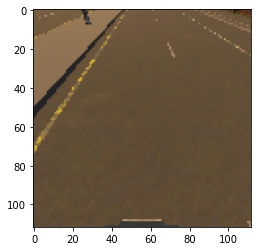

In [20]:
plt.imshow(showed_image)

In [126]:
img = imread(img_x_path)
img = img/255.0
img = img.reshape([1,112,112,3])

In [127]:
result = autoencoder.predict(img)

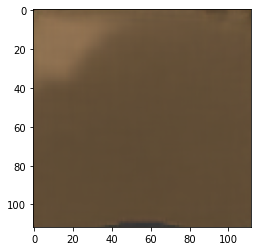

In [128]:
plt.imshow(result.reshape([112,112,3]))

# Testing and visualizing the output

In [18]:
autoencoder.load_weights("autoencoder_5.h5")

In [19]:
img_test_x=np.asarray(training_images[0:1000])
motor_test=np.asarray(training[0:1000])
img_test_y=np.asarray(training_images[1:1001])

In [20]:
result_images = autoencoder.predict([motor_test, img_test_x])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


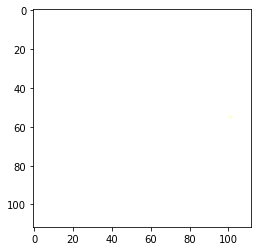

In [21]:
plt.imshow(result_images[800])

In [22]:
goal_img = cv2.normalize(result_images[0] ,None , 0, 1, cv2.NORM_MINMAX)

In [23]:
goal_img

array([[[0.01959432, 0.01643866, 0.01085307],
        [0.01113187, 0.01073424, 0.00712851],
        [0.00975791, 0.00998464, 0.0068828 ],
        ...,
        [0.00999466, 0.00986404, 0.00681999],
        [0.01010691, 0.00996173, 0.00693289],
        [0.01025494, 0.00995201, 0.00695414]],

       [[0.01857688, 0.0149733 , 0.00723211],
        [0.01323458, 0.01297303, 0.00536994],
        [0.0146868 , 0.01508244, 0.01006305],
        ...,
        [0.01141569, 0.01117359, 0.00787739],
        [0.0106555 , 0.0105527 , 0.00742914],
        [0.01025494, 0.00995201, 0.00695414]],

       [[0.0119915 , 0.01716799, 0.01047381],
        [0.01168451, 0.01416348, 0.00602158],
        [0.01241948, 0.01253156, 0.0084496 ],
        ...,
        [0.01025494, 0.00995201, 0.00695414],
        [0.01025494, 0.00995201, 0.00695414],
        [0.01025494, 0.00995201, 0.00695414]],

       ...,

       [[0.7208882 , 0.5734059 , 0.39941034],
        [0.7238808 , 0.5741253 , 0.3971303 ],
        [0.7227456 , 0

In [22]:
img_test_y[0]

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[100,  81,  53],
        [ 99,  80,  52],
        [100,  81,  54],
        ...,
        [100,  79,  55],
        [102,  80,  55],
        [ 99,  79,  56]],

       [[ 99,  81,  54],
        [101,  82,  56],
        [103,  83,  58],
        ...,
        [ 98,  78,  55],
        [101,  79,  55],
        [102,  80,  55]],

       [[102,  83,  57],
        [105,  84,  60],
        [106,  86,  61],
        ...,
        [ 98,  77,  54],
        [100,  78,  54],
        [102,  79,  55]]

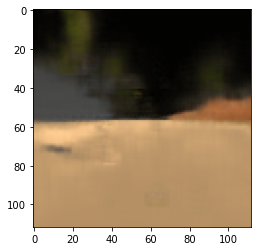

In [24]:
plt.imshow(goal_img)